<a href="https://colab.research.google.com/github/bil-ardhry/fastai_course_22/blob/main/Linear_Model_and_Neural_Net_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Model From Scratch**

## **Notebook Setup**

In [134]:
import pandas as pd
import numpy as np
import torch
import os, json
from pathlib import Path

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [135]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"bachaudhry","key":"a322df186bc33a5f7f95eab45b259102"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Setting up our notebook to download the Titanic dataset from Kaggle.

In [136]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
  path = Path('../input/titanic')
else:
  path = Path('titanic')
  if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [137]:
ls

drive/  sample_data/  titanic/  titanic.zip


## Data Cleaning and Prepping

In [138]:
df = pd.read_csv(path/'train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [139]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [140]:
# Checking if there are nulls in any column
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [141]:
# Replacing missing values with the modes for each column
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [142]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [143]:
# Checking summary statistics
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


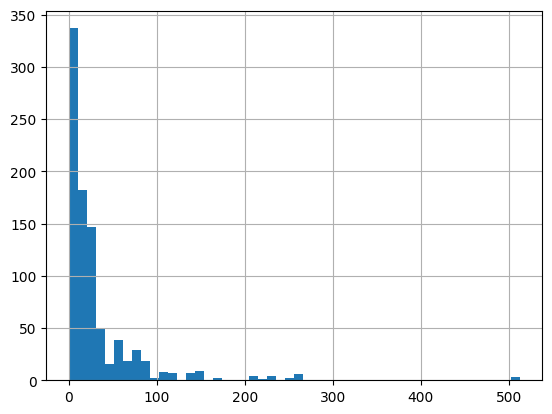

In [144]:
# Fares appear to have extreme outliers
# Visualizing using histogram
df['Fare'].hist(bins=50);

<Axes: >

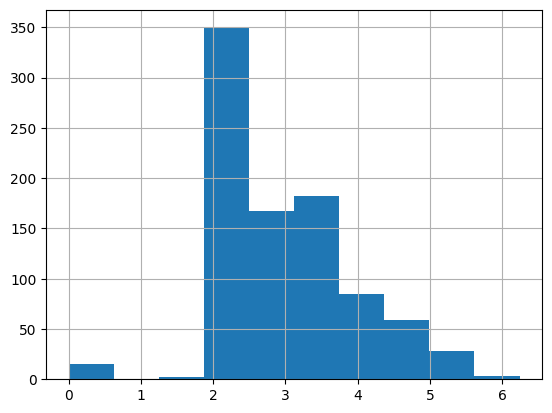

In [145]:
# Ensuring that Fare is log normalized
# We are adding 1 to the log in case there are null values and the log func
# ends up returning inf
df['LogFare'] = np.log(df['Fare'] + 1)
df['LogFare'].hist()

In [146]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [147]:
# Creating dummy variables to columns which are clearly indicate that there are
# underlying categories
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [148]:
# Creating both independent and dependent variables
from torch import tensor

t_dep = tensor(df.Survived)
t_dep

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 

In [149]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_male',
              'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3',
              'Embarked_C', 'Embarked_Q', 'Embarked_S']
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep.shape

torch.Size([891, 12])

## **Setting up a Linear Model**

This section deals solely with the training of a simple linear model, with each step carried out manually.

In [150]:
torch.manual_seed(442)
# Picking randon numbers in the range -0.5 to 0.5 to represent coefficients for
# each column
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [151]:
# Predictions will be calculated by multiplying each row by the coefficients and summing
# them up. The exception being that we won't be adding an intercept due to the
# presence of dummy variables across the dataset
t_indep * coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

Since the sum of each row is dominated by the first column i.e. Age, we will need to normalize the values across the table / DataFrame.

In [152]:
vals, indeces = t_indep.max(dim=0)
# Here we will be dividing a matrix with a vector.
t_indep = t_indep / vals

t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [153]:
# Generating sample predictions
preds = (t_indep * coeffs).sum(axis=1)
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [154]:
# To implement gradient descent, we will add a loss function i.e.
# taking the average error of the rows for starters
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5382)

In [155]:
# Adding the above calculations to functions
def calc_preds(coeffs, indeps):
  return (indeps * coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
  return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

## **Single Step Gradient Descent**

In [156]:
# Enabling the calculation of gradients in PyTorch
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [157]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [158]:
# Calculating gradients
loss.backward()

In [159]:
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [160]:
# Running the above step again
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

In [161]:
# Problem in the cell above is that we didn't reset the gradients to zero after
# carrying out a step of gradient descent
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
  coeffs.sub_(coeffs.grad * 0.1)
  coeffs.grad.zero_()
  print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4945)


## **Training A Linear Model**

In [162]:
# Creating training and validation sets from our data, here fastai
# has a handy transformation function which allows us to carry out this operation
from fastai.data.transforms import RandomSplitter

trn_split, val_split = RandomSplitter(seed=42)(df)

In [163]:
# Applying the above indeces to our independent and dependent variables
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

In [164]:
# Creating functions for updating coeffs, running one GD step and intializing coeffs
# to random numbers
def update_coeffs(coeffs, lr):
  coeffs.sub_(coeffs.grad * lr)
  coeffs.grad.zero_()

def one_epoch(coeffs, lr):
  loss = calc_loss(coeffs, trn_indep, trn_dep)
  loss.backward()
  with torch.no_grad():
    update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def init_coeffs():
  return (torch.rand(n_coeff) - 0.5).requires_grad_()

In [165]:
# Training the model
def train_model(epochs=30, lr=0.01):
  torch.manual_seed(442)
  coeffs = init_coeffs()
  for i in range(epochs):
    one_epoch(coeffs, lr=lr)
  return coeffs

In [166]:
coeffs = train_model(20, lr=0.15)

0.536; 0.510; 0.489; 0.471; 0.454; 0.437; 0.420; 0.404; 0.388; 0.372; 0.358; 0.346; 0.336; 0.328; 0.322; 0.316; 0.321; 0.301; 0.307; 0.296; 

In [167]:
# Display coefficients for each column
def show_coeffs():
  return dict(zip(indep_cols, coeffs.requires_grad_(False)))

show_coeffs()

{'Age': tensor(-0.2799),
 'SibSp': tensor(0.1002),
 'Parch': tensor(0.2422),
 'LogFare': tensor(0.0113),
 'Sex_male': tensor(-0.3937),
 'Sex_female': tensor(0.1826),
 'Pclass_1': tensor(0.7363),
 'Pclass_2': tensor(0.3876),
 'Pclass_3': tensor(0.3241),
 'Embarked_C': tensor(0.0321),
 'Embarked_Q': tensor(0.2427),
 'Embarked_S': tensor(0.2258)}

In [168]:
# Calculating our predictions
preds = calc_preds(coeffs, val_indep)

# Assuming that any passenger with a score of over 0.5 is predicted to survive
results = val_dep.bool() == (preds > 0.5)
results[:15]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True])

In [169]:
# Determining our average accuracy
results.float().mean()

tensor(0.7921)

In [170]:
# Creating a function to measure accuracy
def acc(coeffs):
  return (val_dep.bool()==(calc_preds(coeffs, val_indep) > 0.5)).float().mean()

acc(coeffs)

tensor(0.7921)

In [171]:
# To address the problem of some prediction probabilities being >1 and <0
# we will pass every prediction through a sigmoid function
def calc_preds(coeffs, indeps):
  return torch.sigmoid((indeps * coeffs).sum(axis=1))

In [172]:
# Training the model with the updated function
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [173]:
acc(coeffs)

tensor(0.8258)

In [174]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

## Using Matrix Products

In [175]:
# Tensor representation of the inner most calculation we're doing to get predictions
(val_indep * coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3512, -13.6469,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

In [176]:
# Replicating the above using the @ operator for highly optimized
# matrix calculations in PyTorch
val_indep@coeffs

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

In [177]:
# Using the @ operator on calc_preds
def calc_preds(coeffs, indeps):
  return torch.sigmoid(indeps@coeffs)

# To carry out matrix-matrix products we will convert coeffs into a column vector
def init_coeffs():
  return (torch.rand(n_coeff, 1) * 0.1).requires_grad_()

In [178]:
# Converting our dependent variable into a column vector
trn_dep = trn_dep[:, None]

In [179]:
# Doing the same for val_dep
val_dep = val_dep[:, None]
val_dep

tensor([[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

In [180]:
# Training our model as before, and we will get identical outputs
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [181]:
acc(coeffs)

tensor(0.8258)

## **Using A Neural Network With A Single Hidden Layer**

In [196]:
# To setup our Neural Network - let's carry out the necessary steps in a custom
# function. The first step creates coefficients for each layer. The first layer
# takes n_coeff inputs and creates n_hidden outputs. Let's set n_hidden to 20.
def init_coeffs(n_hidden=20):
  # For the first layer, we need to divide the coeffs with n_hidden to get a
  # matrix of size n_coeff x n_hidden
  layer1 = (torch.rand(n_coeff, n_hidden) - 0.5) / n_hidden
  # In this layer, we will take n_hidden to create a single output i.e.
  # n_hidden by 1. A constant term is also added.
  layer2 = torch.rand(n_hidden, 1) - 0.3
  const = torch.rand(1)[0]
  return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [197]:
# Since we have our coeffs, we can create our neural network.
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
  l1, l2, const = coeffs
  # We will carry out matrix products where the first layer output is passed to
  # F.relu and the second is passed to torch.sigmoid
  res = F.relu(indeps@l1)
  res = res@l2 + const
  return torch.sigmoid(res)

In [198]:
# Adding a loop to update our coeffs
def update_coeffs(coeffs, lr):
  for layer in coeffs:
    layer.sub_(layer.grad * lr)
    layer.grad.zero_()

In [199]:
# Training the model
coeffs = train_model(lr=1.4)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 

In [200]:
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [201]:
acc(coeffs)

tensor(0.8258)

## **Using Deep Learning for the Above**



In [206]:
# Creating additional coefficients for each layer
# The constants used below have been added to generate random initializations
# in the correct ranges.
def init_coeffs():
  hiddens = [10, 10]
  sizes = [n_coeff] + hiddens + [1]
  n = len(sizes)
  layers = [(torch.rand(sizes[i], sizes[i+1])-0.3) /
            sizes[i+1]*4 for i in range(n-1)]
  consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
  for l in layers + consts:
    l.requires_grad_()
  return layers, consts

# Adding loops for each hidden layer in calc_preds
def calc_preds(coeffs, indeps):
  layers, consts = coeffs
  n = len(layers)
  res = indeps
  for i, l in enumerate(layers):
    res = res@l + consts[i]
    if i != n-1:
      res = F.relu(res)
  return torch.sigmoid(res)


# We will also need to update our coeffs as layers and consts are separate now
def update_coeffs(coeffs, lr):
  layers, consts = coeffs
  for layer in layers + consts:
    layer.sub_(layer.grad * lr)
    layer.grad.zero_()

In [207]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [208]:
acc(coeffs)

tensor(0.8258)